# 🛒 Amazon Bestsellers Analysis 2025
This notebook provides an in-depth analysis of Amazon’s 2025 bestsellers dataset, covering price, ratings, brands, countries, and more.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

# 1. Dataset Overview
We begin by loading the dataset and examining its structure:

- **Shape**: number of rows and columns.  
- **Columns**: list of all features.  
- **Data types**: numerical vs categorical fields.  
- **Missing values**: identify incomplete data.  
- **Sample rows**: first 5 entries.  
- **Basic statistics**: summary of numerical columns.  



In [2]:
df = pd.read_csv(r"C:\Users\USER\Desktop\CodeProjects\BestSellersAmazon\data\Amazon_bestsellers_items_2025.csv")
print("Dataset Overview:")
print(df.shape) 
print("\nColumns:")
print(df.columns.tolist()) 
print("\nData Types:")
print(df.dtypes)           
print("\nMissing Values:")
print(df.isnull().sum())   
print("\nFirst 5 rows:")
print(df.head())           
print("\nBasic Statistics:")
print(df.describe())   

mv_cnt = df.isna().sum()
mv_pct = df.isna().mean().mul(100).round(1)
missing_table = (
    pd.DataFrame({"missing_count": mv_cnt, "missing_pct": mv_pct})
    .sort_values("missing_pct", ascending=False)
)
display(missing_table)



Dataset Overview:
(999, 12)

Columns:
['Unnamed: 0', 'rank', 'asin', 'product_title', 'product_price', 'product_star_rating', 'product_num_ratings', 'product_url', 'product_photo', 'rank_change_label', 'country', 'page']

Data Types:
Unnamed: 0               int64
rank                     int64
asin                    object
product_title           object
product_price           object
product_star_rating    float64
product_num_ratings    float64
product_url             object
product_photo           object
rank_change_label      float64
country                 object
page                     int64
dtype: object

Missing Values:
Unnamed: 0               0
rank                     0
asin                     0
product_title            0
product_price           54
product_star_rating     30
product_num_ratings     30
product_url              0
product_photo            0
rank_change_label      999
country                  0
page                     0
dtype: int64

First 5 rows:
   Unnamed:

,missing_count,missing_pct
rank_change_label,999,100.0
product_price,54,5.4
product_star_rating,30,3.0
product_num_ratings,30,3.0
product_title,0,0.0
asin,0,0.0
rank,0,0.0
Unnamed: 0,0,0.0
product_url,0,0.0
product_photo,0,0.0


## 1.1 Missing Values Heatmap  

To better understand data quality, we visualize missing values across all columns:  
- Each yellow cell represents a missing value.  
- Helps identify problematic features that may require cleaning or imputation.  


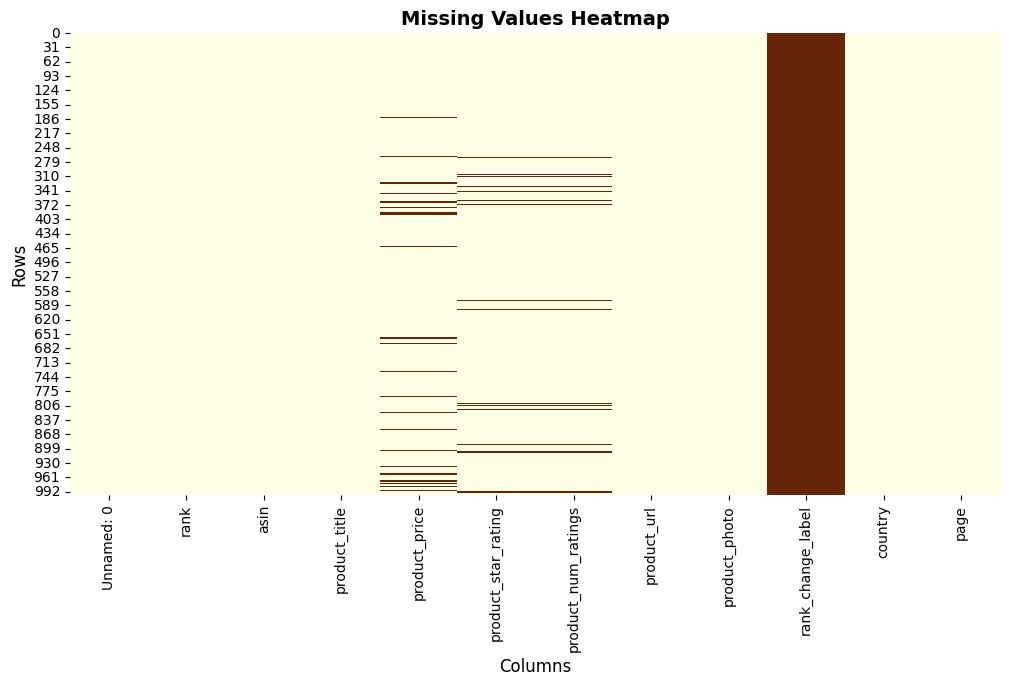

In [3]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap="YlOrBr")
plt.title("Missing Values Heatmap", fontsize=14, weight="bold")
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Rows", fontsize=12)
plt.show()


## 1.2 Data Quality Checks  
We perform additional checks to ensure dataset reliability:  

- **Drop technical columns**: remove index-like columns such as `Unnamed: 0`.  
- **Type casting**: convert numeric-like columns (`rank`, `page`, `product_num_ratings`) safely to numeric.  
- **Normalize missing values**: fill missing values in `country` with `"Unknown"`.  
- **Duplicate removal**: drop exact duplicate rows and report how many were removed.  
- **Categorical distributions**: inspect dominant values in selected categorical fields.  
- **Outliers**: review extreme values in numeric features using extended percentiles.  

### Categorical Distributions  
We examine the most frequent values for selected categorical fields to understand dataset composition.  

### Numerical Distributions and Outliers  
We review extended percentiles for numeric fields to check for extreme values and potential outliers.  


In [4]:
for col in ['Unnamed: 0', 'rank_change_label']:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"Dropped column: {col}")

for col in ['rank', 'page', 'product_num_ratings', 'product_num_reviews']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

if 'country' in df.columns:
    df['country'] = df['country'].fillna('Unknown')

before = len(df)
df = df.drop_duplicates()
removed = before - len(df)
print(f"Removed {removed} duplicate rows.") if removed else print("No duplicate rows found.")

if 'rank' in df.columns:
    df['rank_inv'] = -df['rank']
    print("Created feature: rank_inv (inverse of rank)")
    print("Shape after Data Quality Checks:", df.shape)



Dropped column: Unnamed: 0
Dropped column: rank_change_label
No duplicate rows found.
Created feature: rank_inv (inverse of rank)
Shape after Data Quality Checks: (999, 11)


In [5]:
candidate_cats = ['country', 'brand', 'product_category', 'category', 'main_category']
for col in candidate_cats:
    if col in df.columns:
        print(f"\nTop values for {col}:")
        print(df[col].value_counts(dropna=False).head(10))

num_cols = df.select_dtypes(include='number').columns
if len(num_cols) > 0:
    print("\nNumerical summary with extended percentiles:")
    print(df[num_cols].describe(percentiles=[0.01, 0.05, 0.95, 0.99]).T)




Top values for country:
country
IN    100
CA    100
IT    100
AU    100
DE    100
FR    100
JP    100
ES    100
MX    100
US     99
Name: count, dtype: int64

Numerical summary with extended percentiles:
                     count         mean          std    min     1%    5%  \
rank                 999.0    50.450450    28.852421    1.0   1.98   5.9   
product_star_rating  969.0     4.140248     0.496382    1.0   2.80   3.3   
product_num_ratings  969.0  1312.546956  3025.241537    1.0   1.00   3.0   
page                 999.0     1.499499     0.500250    1.0   1.00   1.0   
rank_inv             999.0   -50.450450    28.852421 -100.0 -99.00 -95.0   

                       50%      95%       99%      max  
rank                  50.0    95.00     99.00    100.0  
product_star_rating    4.2     4.86      5.00      5.0  
product_num_ratings  218.0  6483.00  15321.20  19189.0  
page                   1.0     2.00      2.00      2.0  
rank_inv             -50.0    -5.90     -1.98     -1.

## 1.3 Price Cleaning  
The `product_price` column is cleaned to extract numeric values:  
- Remove currency symbols and thousand separators.  
- Handle decimal formats (dot/comma).  
- Convert to float or NaN if invalid.  


In [6]:
def clean_price_value(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    s = str(x).strip()
    s = s.replace('\u2009', '').replace(' ', '')
    s = re.sub(r'[^\d,.\-]', '', s)
    if ',' in s and '.' in s:
        s = s.replace(',', '')
    elif ',' in s and '.' not in s:
        s = s.replace(',', '.')
    m = re.search(r'-?\d+(\.\d+)?', s)
    return float(m.group(0)) if m else np.nan

df['clean_price'] = df['product_price'].apply(clean_price_value)

print("After Price Cleaning:")
print(" - Shape:", df.shape)
print(" - Missing clean_price values:", df['clean_price'].isna().sum())
print(" - Example cleaned values:")
print(df[['product_price', 'clean_price']].head(10))


After Price Cleaning:
 - Shape: (999, 12)
 - Missing clean_price values: 54
 - Example cleaned values:
  product_price  clean_price
0       ₹469.00        469.0
1       ₹370.00        370.0
2     ₹1,799.00       1799.0
3        ₹94.00         94.0
4     ₹1,699.00       1699.0
5       ₹599.00        599.0
6     ₹1,199.00       1199.0
7       ₹745.00        745.0
8     ₹5,000.00       5000.0
9       ₹599.00        599.0


## 1.3.2 Currency Normalization  

After cleaning raw price strings, we normalize all prices to a **single currency (USD)** for consistency across countries:  

- Each country is mapped to its local currency.  
- Fixed exchange rates are applied to convert all values into USD.  
- This ensures that further analysis (comparisons, distributions, averages) is not distorted by differences in local currencies.  

Example:  
- India (INR → USD), Japan (JPY → USD), Germany/France/Italy/Spain (EUR → USD).  
- All values are unified under the `clean_price` column, now expressed in USD.  


In [7]:
country_currency_map = {
    "IN": "INR",
    "CA": "CAD",
    "IT": "EUR",
    "AU": "AUD",
    "DE": "EUR",
    "FR": "EUR",
    "JP": "JPY",
    "ES": "EUR",
    "MX": "MXN",
    "US": "USD"
}

currency_rates_to_usd = {
    "USD": 1.00,
    "EUR": 1.09,
    "GBP": 1.27, 
    "INR": 0.012,
    "JPY": 0.0067,   
    "CAD": 0.73,
    "AUD": 0.67,
    "MXN": 0.06,
}

df['currency'] = df['country'].map(country_currency_map)

def convert_price(row):
    rate = currency_rates_to_usd.get(row['currency'], np.nan)
    price = row['clean_price']
    if row['currency'] == "JPY" and price < 50:  
        price = price * 100
    return price * rate

df['clean_price'] = df.apply(convert_price, axis=1)

print("After Currency Normalization:")
print(" - Shape:", df.shape)
print(" - Missing clean_price values:", df['clean_price'].isna().sum())
print(df[df['country'] == "JP"][['country','product_price','currency','clean_price']].head(10))


After Currency Normalization:
 - Shape: (999, 13)
 - Missing clean_price values: 54
    country product_price currency  clean_price
799      JP        ￥3,564      JPY      2.38788
800      JP       ￥31,023      JPY     20.78541
801      JP       ￥14,600      JPY      9.78200
802      JP       ￥13,900      JPY      9.31300
803      JP       ￥39,582      JPY     26.51994
804      JP        ￥2,970      JPY      1.98990
805      JP        ￥1,297      JPY      0.86899
806      JP       ￥10,780      JPY      7.22260
807      JP          ￥350      JPY      2.34500
808      JP        ￥3,970      JPY      2.65990


## 1.4 Rating Cleaning
We sanitize rating-related fields to ensure valid numerics:

- **`product_star_rating`** → float in the range **[0, 5]**.
- **`product_num_ratings`**, **`product_num_reviews`** (if present) → non-negative integers.
- Strip stray characters (e.g., "4.5 out of 5").
- Report before/after stats to validate changes.


In [8]:
def _to_float_safe(x):
    if x is None:
        return np.nan
    s = str(x).strip()
    m = re.search(r'-?\d+(\.\d+)?', s)
    return float(m.group(0)) if m else np.nan

def _to_int_safe_nonneg(x):
    if x is None:
        return np.nan
    s = str(x).strip()
    m = re.search(r'-?\d+', s)  
    v = int(m.group(0)) if m else np.nan
    if pd.isna(v):
        return np.nan
    return max(v, 0)

if 'product_star_rating' in df.columns:
    print("Ratings BEFORE cleaning:")
    print(df['product_star_rating'].head(10).to_string(index=False))
    print(df['product_star_rating'].describe())

if 'product_star_rating' in df.columns:
    df['product_star_rating'] = df['product_star_rating'].apply(_to_float_safe)
    df['product_star_rating'] = df['product_star_rating'].clip(lower=0, upper=5)

for col in ['product_num_ratings', 'product_num_reviews']:
    if col in df.columns:
        df[col] = df[col].apply(_to_int_safe_nonneg)

if 'product_star_rating' in df.columns:
    print("\nRatings AFTER cleaning:")
    print(df['product_star_rating'].head(10).to_string(index=False))
    print(df['product_star_rating'].describe())
df = df[~df['product_star_rating'].isna()] 
print("Number of missing ratings:", df['product_star_rating'].isna().sum())
print("Shape after Rating Cleaning:", df.shape)



Ratings BEFORE cleaning:
4.3
4.4
4.5
4.1
4.4
4.4
4.3
4.1
3.6
4.5
count    969.000000
mean       4.140248
std        0.496382
min        1.000000
25%        3.900000
50%        4.200000
75%        4.400000
max        5.000000
Name: product_star_rating, dtype: float64

Ratings AFTER cleaning:
4.3
4.4
4.5
4.1
4.4
4.4
4.3
4.1
3.6
4.5
count    969.000000
mean       4.140248
std        0.496382
min        1.000000
25%        3.900000
50%        4.200000
75%        4.400000
max        5.000000
Name: product_star_rating, dtype: float64
Number of missing ratings: 0
Shape after Rating Cleaning: (969, 13)


## 1.5 Correlation Matrix (Cleaned Features)

We calculate correlations **only** on cleaned numeric features:

- `clean_price` — numeric price after cleaning  
- `product_star_rating` — rating cleaned and clipped to [0, 5]  
- `product_num_ratings`, `product_num_reviews` — if available  
- `rank_inv` — inverse of bestseller rank  

This ensures that the heatmap is reliable, focused on numeric features, and excludes irrelevant or categorical fields.


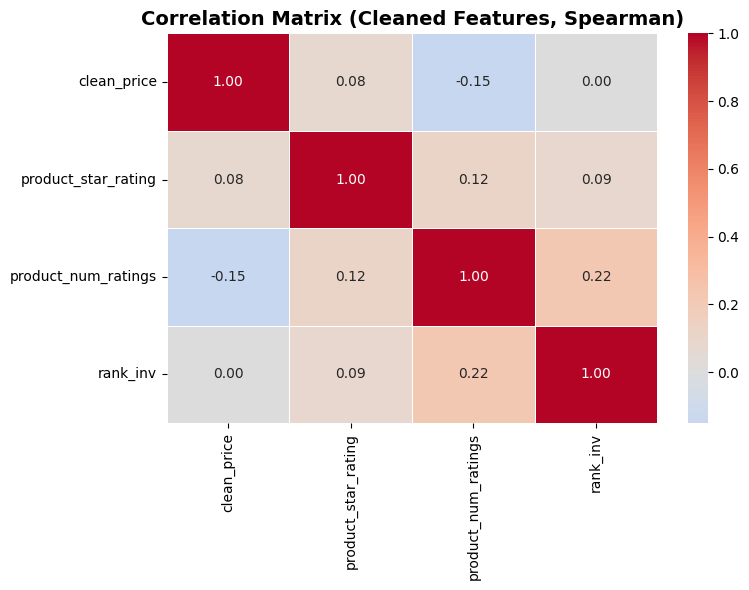


Correlation table (Spearman):
                     clean_price  product_star_rating  product_num_ratings  \
clean_price             1.000000             0.077505            -0.150361   
product_star_rating     0.077505             1.000000             0.115761   
product_num_ratings    -0.150361             0.115761             1.000000   
rank_inv                0.003019             0.086893             0.221512   

                     rank_inv  
clean_price          0.003019  
product_star_rating  0.086893  
product_num_ratings  0.221512  
rank_inv             1.000000  
Shape before Country Analysis: (969, 13)


In [9]:
candidate_cols = [
    'clean_price',
    'product_star_rating',
    'product_num_ratings',
    'product_num_reviews',
    'rank_inv',
]

cols = [c for c in candidate_cols if c in df.columns]

if len(cols) < 2:
    print("Not enough cleaned numeric features for correlation.")
else:
    corr_df = df[cols].apply(pd.to_numeric, errors='coerce').dropna(how='all')
    variances = corr_df.var(numeric_only=True)
    keep = variances[variances > 1e-9].index.tolist()
    corr_df = corr_df[keep]

    if corr_df.shape[1] < 2:
        print("After cleaning, fewer than 2 numeric columns remain; skipping correlation.")
    else:
        corr = corr_df.corr(method='spearman')
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
        plt.title("Correlation Matrix (Cleaned Features, Spearman)", fontsize=14, weight="bold")
        plt.tight_layout()
        plt.show()
        print("\nCorrelation table (Spearman):")
        print(corr)

        print("Shape before Country Analysis:", df.shape)



# 2. Products by Country
We analyze product distribution across markets:

- **Value counts**: number of products per country.  
- **Visualization**: Bar chart shows product counts per country, making it easier to compare across regions.  



Products by Country:
  country  count
0      IN    100
1      DE    100
2      ES    100
3      US     99
4      IT     99
5      CA     98
6      FR     96
7      MX     95
8      JP     93
9      AU     89


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\1008275494.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


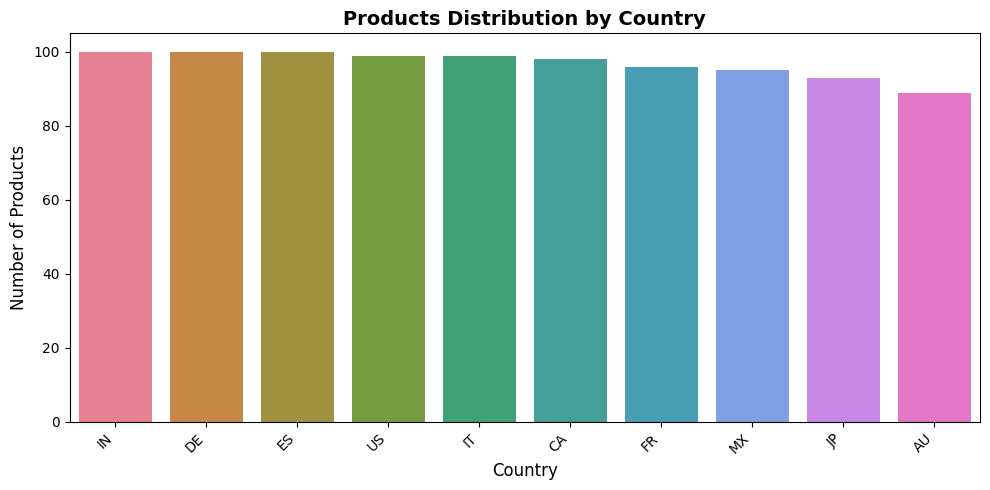

In [10]:
print("\nProducts by Country:")
country_counts = (
    df['country']
      .value_counts(dropna=False)
      .rename_axis('country')
      .reset_index(name='count')
)
print(country_counts.head(10))

plt.figure(figsize=(10, 5))
sns.barplot(
    data=country_counts,
    x='country',
    y='count',
    palette="husl"
)
plt.title("Products Distribution by Country", fontsize=14, weight="bold")
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Products", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 2.1 Average Metrics by Country

We compare country-level averages using the already-cleaned `clean_price`:

- **Average star rating** (`product_star_rating`)
- **Average price** (`clean_price`)
- **Sample size** per country (for context)


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\1395766256.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_10828\1395766256.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0, 0.5, 'Avg Price')

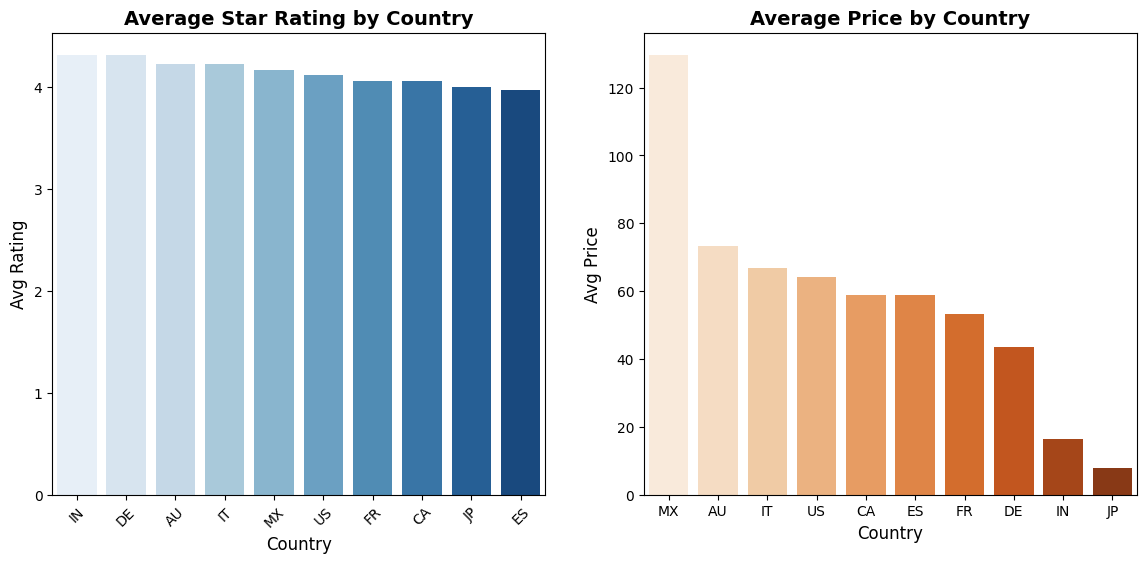

In [11]:
if 'clean_price' not in df.columns:
    raise ValueError("`clean_price` column is missing. Run section 1.4 (Price Cleaning) first.")

stats = (
    df.groupby('country', dropna=False)
      .agg(
          n_items=('product_title', 'count'),
          avg_rating=('product_star_rating', 'mean'),
          avg_price=('clean_price', 'mean')
      )
      .reset_index()
)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax1, ax2 = axes

sns.barplot(
    data=stats.sort_values('avg_rating', ascending=False),
    x='country', y='avg_rating', palette="Blues", ax=ax1
)
ax1.set_title("Average Star Rating by Country", fontsize=14, weight="bold")
ax1.set_xlabel("Country", fontsize=12)
ax1.set_ylabel("Avg Rating", fontsize=12)
ax1.tick_params(axis='x', rotation=45)

sns.barplot(
    data=stats.sort_values('avg_price', ascending=False),
    x='country', y='avg_price', palette="Oranges", ax=ax2
)
ax2.set_title("Average Price by Country", fontsize=14, weight="bold")
ax2.set_xlabel("Country", fontsize=12)
ax2.set_ylabel("Avg Price", fontsize=12)


## 2.2 Price Distribution by Country (Boxplot, Log Scale)

We compare price distributions across countries:
- Boxplots display median and spread per country.
- A logarithmic y-axis improves readability by reducing the effect of extreme outliers.


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\547716327.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


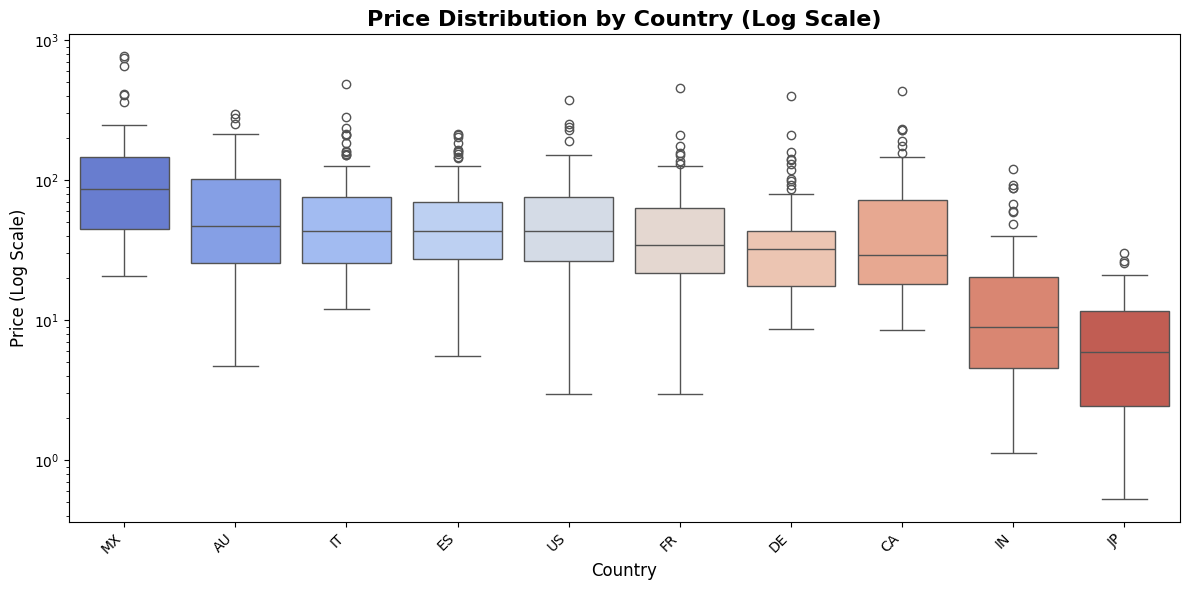

In [12]:
if 'clean_price' not in df.columns:
    raise ValueError("`clean_price` is missing. Run section 1.4 (Price Cleaning) first.")

order = (
    df.dropna(subset=['clean_price'])
      .groupby('country')['clean_price'].median()
      .sort_values(ascending=False)
      .index
)
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df.dropna(subset=['clean_price']),
    x='country',
    y='clean_price',
    order=order,
    palette="coolwarm"
)
plt.yscale("log")
plt.title("Price Distribution by Country (Log Scale)", fontsize=16, weight="bold")
plt.xlabel("Country", fontsize=12)
plt.ylabel("Price (Log Scale)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 3. Brand Analysis
### 3.1 Extract Brands (Aliases)
Mapping product titles to standardized brand names using a dictionary of aliases.

In [13]:
def extract_brand_hybrid(title):
    brand_aliases = {
        "Microsoft": ["microsoft", "windows", "win", "ms", "mso", "server", "pc", "virtual"],
        "Adobe": ["adobe", "acrobat", "creative cloud", "photoshop"],
        "Apple": ["apple"],
        "Norton": ["norton", "ノートンライフロック"],
        "Kaspersky": ["kaspersky"],
        "McAfee": ["mcafee", "【公式】マカフィー"],
        "Bitdefender": ["bitdefender"],
        "ESET": ["eset", "nod32"],
        "Quick Heal": ["quick heal"],
        "K7": ["k7"],
        "AVG": ["avg"],
        "Webroot": ["webroot"],
        "Malwarebytes": ["malwarebytes"],
        "NordVPN": ["nordvpn", "nordpass"],
        "Mullvad": ["mullvad"],
        "Corel": ["corel"],
        "Nero": ["nero"],
        "Laplink": ["laplink", "pcmover", "pc mover"],
        "TurboTax": ["turbotax"],
        "WISO": ["wiso"],
        "Avast": ["avast"],
        "Net Protector": ["net protector", "npav"],
        "Guardian": ["guardian"],
        "Techlocker": ["techlocker", "tech-shop-pro"],
        "CCleaner": ["ccleaner"],
        "eScan": ["escan"],
        "Autodesk": ["autocad"],
        "Wyze": ["wyze"],
        "H&R Block": ["h&r block"],
        "Quicken": ["quicken"],
        "Roxio": ["roxio"],
        "TrulyOffice": ["trulyoffice"],
        "Synology": ["synology"],
        "Intuit QuickBooks": ["qbdt", "quickbooks", "quick books", "quickbooks desktop"],
        "Ralix": ["ralix"],
        "Hallmark": ["hallmark"],
        "G DATA": ["g data"],
        "Panda": ["panda", "panda dome"],
        "Sourcenext": ["ソースネクスト", "sourcenext", "hd革命", "copydrive", "zero ウイルスセキュリティ", "zero"],
        "AHS": ["ahs", "synthesizer v"],
        "Arturia": ["arturia"],
        "Roland": ["roland"],
        "Individual Software": ["individual software"],
        "BeckerCAD": ["beckercad"],
        "JustSystems": ["一太郎", "ichitaro"],
        "Jungle": ["ジャングル", "jungle"],
        "OfficeSuite": ["officesuite", "openoffice", "open office"],
        "Image-Line": ["fl studio", "audio deluxe", "audiodeluxe"],
        "Yayoi": ["弥生", "yayoi", "やよい"],
        "Hatsune Miku": ["初音ミク", "hatsune miku"],
        "Kingsoft": ["wps office", "kingsoft", "キングソフト"],
        "Movavi": ["movavi"],
        "iFIT": ["ifit"],
        "Shure": ["shure"],
        "Lidl Steuer": ["lidl steuer"],
        "Surfshark": ["surfshark", "surfshark one"],
        "CLIP Studio": ["clip studio", "clipstudio", "clip studio paint", "tabmate", "celsys"],
        "MAGIX": ["magix"],
        "Evercade": ["evercade"],
        "Lapin Malin": ["lapin malin"],
        "ClearClick": ["clearclick"],
        "Trend Micro": ["trend micro", "maximum security", "ウイルスバスター"],
        "Antidote": ["antidote"],
        "Audio-Technica": ["audio-technica", "audiotechnica"],
        "Yamaha": ["yamaha"],
        "DocuWorks": ["docuworks"],
        "SteuerSparErklärung": ["steuersparerklärung", "steuer spar erklärung"],
        "Intel": ["intel"],
        "Readiris": ["readiris"],
        "VIDBOX": ["vidbox"],
        "HackyPi": ["hackypi"],
        "Behringer": ["behringer"],
        "VMware": ["vmware"],
        "Audials": ["audials"],
        "Moho": ["moho"],
        "Kenwood": ["kenwood"],
        "Avira": ["avira"],
        "ARC Studio": ["arc studio"],
        "Tascam": ["tascam"],
        "Pinnacle Studio": ["pinnacle studio"],
        "Linux Mint": ["linux mint"],
        "QuickSteuer": ["quicksteuer", "quick steuer"],
        "Square Enix": ["square enix", "ドラゴンクエスト", "dragon quest", "final fantasy"],
        "Spectrasonics": ["spectrasonics", "omnisphere"],
        "CyberLink": ["cyberlink", "powerdvd"],
        "Fudegrume": ["筆ぐるめ", "fudegrume"],
        "EA": ["ea", "electronic arts", "need for speed", "nfs"],
        "BRIDGE Expert": ["bridge expert", "bridge"],
        "Tax Software": ["tax", "taxman"],
        "Video Tools": ["video", "videokassetten"],
        "Type-Moon": ["fate/grand", "fate grand order"],
        "Kadokawa": ["ロード・エルメロイ", "東方錦上京"],
        "Games": ["stubbs", "slay", "maverick", "anno", "lemon", "tetris", "truth", "retro", "let", "jack"],
        "ALDI": ["aldi"],
        "Adibou": ["adibou"],
        "F-Secure": ["f-secure", "fsecure"],
        "Key": ["key", "key studio", "key アニメ"],
        "AOS Data": ["aosデータ", "aos data"],
        "IBM": ["ibm"],
        "TP-Link": ["tp-link", "tplink"],
        "Audio Gear": ["pedal", "mezclador", "efecto", "oumij", "vikye", "elsky"],
        "Entertainment": ["hollow", "miller's", "the", "one"]
    }

    if not isinstance(title, str):
        return "Other"

    t = title.lower()
    for brand, aliases in brand_aliases.items():
        for alias in aliases:
            if alias in t:
                return brand
    return "Other"

df['brand'] = df['product_title'].apply(extract_brand_hybrid)


### 3.2 Brand Counts
Counting the number of products per brand to identify leading brands.

In [14]:
brand_counts = df['brand'].value_counts()
print("\nTop Brands by Number of Products:")
print(brand_counts.head(25))



Top Brands by Number of Products:
brand
Microsoft        513
Kaspersky         72
McAfee            69
Norton            67
NordVPN           58
Quick Heal        11
Games              9
EA                 8
Adobe              8
ESET               7
K7                 6
Entertainment      6
Mullvad            6
Corel              6
Nero               6
Audio Gear         6
Avast              5
Sourcenext         5
Other              5
AVG                4
Bitdefender        4
Panda              4
Synology           3
Surfshark          3
CLIP Studio        3
Name: count, dtype: int64


### 3.3 Brand Stats (Products + Rating)
After extracting brands, we calculate key metrics for each:

- **Products**: Total number of items per brand.  
- **Average Rating**: Mean customer star rating across products.  
- **Sorting**: Results are sorted by product count to highlight leading brands.  

This provides both volume (how many products a brand has) and quality (average rating).  

In [15]:
brand_stats = (
    df.groupby('brand')
    .agg(
        products=('product_title', 'count'),
        avg_rating=('product_star_rating', 'mean')
    )
    .sort_values('products', ascending=False)
)

print("\nTop Brands with Product Count and Average Rating:")
print(brand_stats.head(25))



Top Brands with Product Count and Average Rating:
               products  avg_rating
brand                              
Microsoft           513    4.089279
Kaspersky            72    4.509722
McAfee               69    4.178261
Norton               67    4.070149
NordVPN              58    4.153448
Quick Heal           11    4.300000
Games                 9    4.422222
EA                    8    4.337500
Adobe                 8    3.612500
ESET                  7    4.200000
Audio Gear            6    4.333333
Mullvad               6    4.733333
Entertainment         6    4.666667
K7                    6    4.250000
Nero                  6    3.666667
Corel                 6    4.016667
Avast                 5    4.040000
Other                 5    4.360000
Sourcenext            5    4.100000
Panda                 4    4.275000
Bitdefender           4    4.200000
AVG                   4    3.775000
Evercade              3    4.533333
CLIP Studio           3    4.033333
Synology     

### 3.4 Visualization: Products vs Rating (Bar + Line)

This visualization combines **brand popularity** and **customer satisfaction**:

- **Bar chart (left axis)**: number of products per brand.  
- **Line chart (right axis)**: average customer rating for each brand.  

This dual-axis chart helps identify whether the most represented brands are also the ones with the highest ratings.


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\3685224084.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


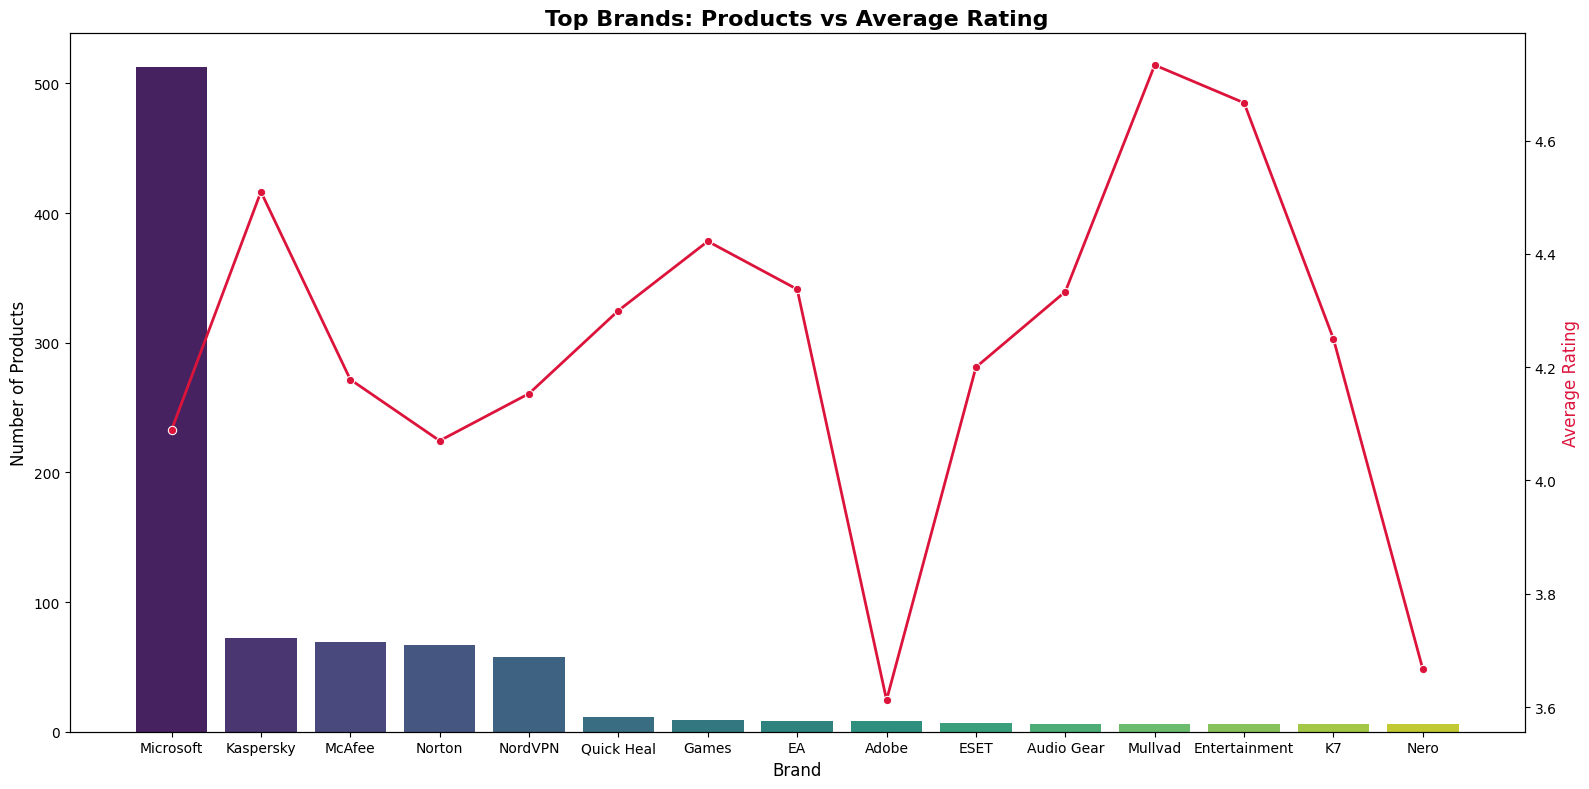

In [16]:
top_brands = brand_stats.head(15).reset_index()

fig, ax1 = plt.subplots(figsize=(16,8))

sns.barplot(
    data=top_brands,
    x="brand",
    y="products",
    palette="viridis",
    ax=ax1
)
ax1.set_ylabel("Number of Products", fontsize=12, color="black")
ax1.set_xlabel("Brand", fontsize=12)
ax1.set_title("Top Brands: Products vs Average Rating", fontsize=16, weight="bold")

ax2 = ax1.twinx()
sns.lineplot(
    data=top_brands,
    x="brand",
    y="avg_rating",
    color="crimson",
    marker="o",
    linewidth=2,
    ax=ax2
)
ax2.set_ylabel("Average Rating", fontsize=12, color="crimson")

plt.xticks(rotation=45, ha="right")
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()


### 3.5 Brand Grouping

To simplify brand-level analysis, we define a grouping function:

- **Thematic grouping**: Map brands into categories (e.g., Security, Office/Productivity, Creative/Audio/Video, Gaming, Finance/Tax, Utilities).  
- **Threshold grouping**: Collapse smaller brands (less than a chosen threshold) into an "Other Small Brands" category.  
- **Top-N grouping**: Keep the most common `N` brands, assign the rest to "Other".  

This function allows flexible categorization of brands for more meaningful visualizations.


In [17]:
def group_brands(df, method="thematic", threshold=10, top_n=10):
    if method == "thematic":
        group_map = {
            "Security": ["Norton", "McAfee", "Kaspersky", "Avast", "Bitdefender", "ESET", "Panda", "Webroot", "Quick Heal"],
            "Office/Productivity": ["Microsoft", "Adobe", "Corel", "OfficeSuite", "Kingsoft"],
            "Creative/Audio/Video": ["CLIP Studio", "MAGIX", "Pinnacle Studio", "Audio Gear", "Spectrasonics", "Movavi", "Roland", "Yamaha", "Arturia", "Shure"],
            "Gaming/Entertainment": ["EA", "Square Enix", "Kadokawa", "Games", "Entertainment", "Hatsune Miku", "Evercade"],
            "Finance/Tax": ["TurboTax", "H&R Block", "Quicken", "Tax Software", "QuickSteuer", "WISO", "Lidl Steuer", "Yayoi"],
            "Utilities/Tools": ["CCleaner", "VMware", "Intel", "TP-Link", "Synology", "F-Secure"]
        }
        def map_group(brand):
            for group, brands in group_map.items():
                if brand in brands:
                    return group
            return "Other"
        df['brand_grouped'] = df['brand'].apply(map_group)

    elif method == "threshold":
        brand_counts = df['brand'].value_counts()
        small_brands = brand_counts[brand_counts < threshold].index
        df['brand_grouped'] = df['brand'].apply(lambda x: x if x not in small_brands else "Other Small Brands")

    elif method == "top_n":
        brand_counts = df['brand'].value_counts()
        top_brands = brand_counts.head(top_n).index
        df['brand_grouped'] = df['brand'].apply(lambda x: x if x in top_brands else "Other")

    return df


In [18]:
df['brand_grouped_thematic']  = group_brands(df.copy(), method="thematic")['brand_grouped']
df['brand_grouped_threshold'] = group_brands(df.copy(), method="threshold", threshold=10)['brand_grouped']
df['brand_grouped_topn']      = group_brands(df.copy(), method="top_n", top_n=10)['brand_grouped']


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\1774386563.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, ax=ax, palette="husl")
C:\Users\USER\AppData\Local\Temp\ipykernel_10828\1774386563.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, ax=ax, palette="husl")
C:\Users\USER\AppData\Local\Temp\ipykernel_10828\1774386563.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, ax=ax, palette="husl")


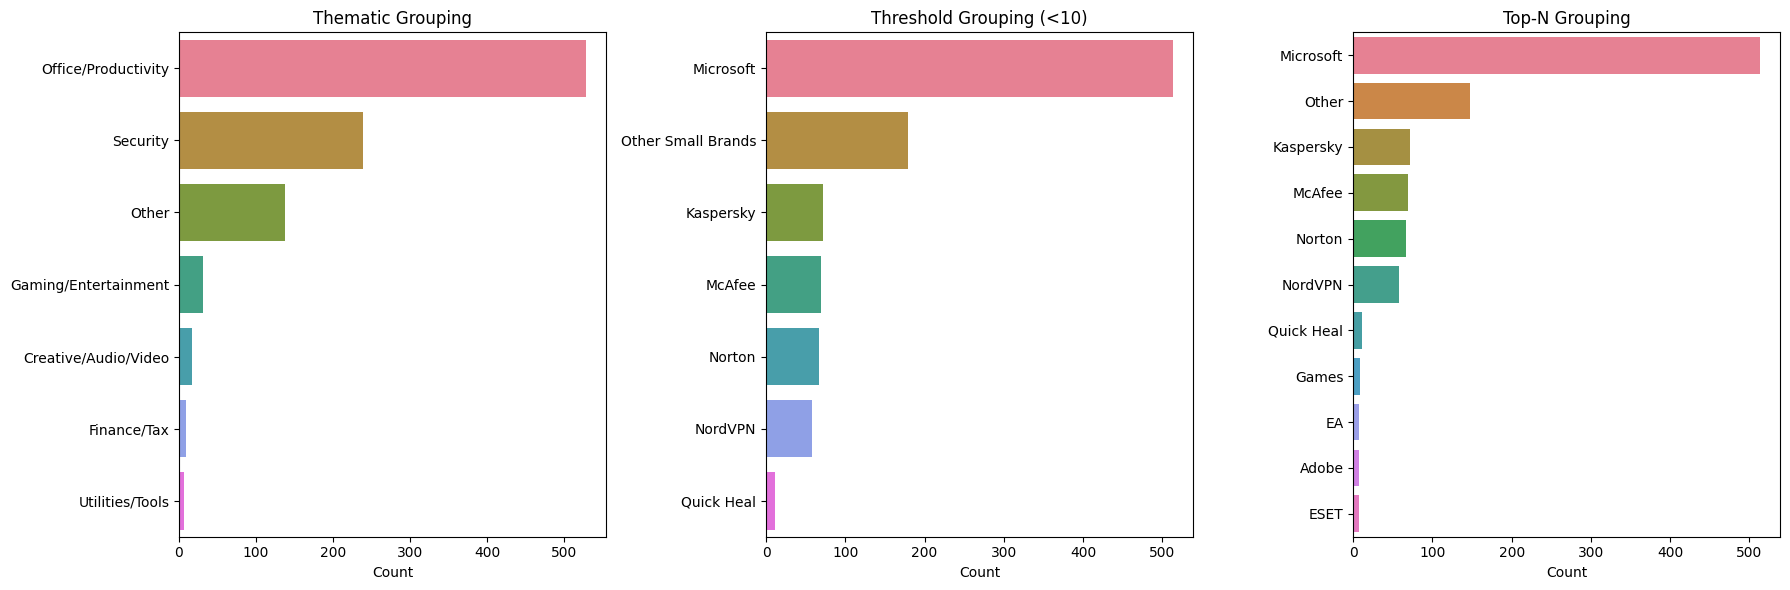

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

for ax, col, title in zip(
    axes,
    ['brand_grouped_thematic', 'brand_grouped_threshold', 'brand_grouped_topn'],
    ['Thematic Grouping', 'Threshold Grouping (<10)', 'Top-N Grouping']
):
    counts = df[col].value_counts()
    sns.barplot(x=counts.values, y=counts.index, ax=ax, palette="husl")
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

### 3.6 Grouped Brand Distribution

This bar plot displays the **number of products per grouped brand category**.  
It highlights which thematic or aggregated groups dominate the dataset, making it easier to spot broader trends beyond individual brands.


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\3866903538.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


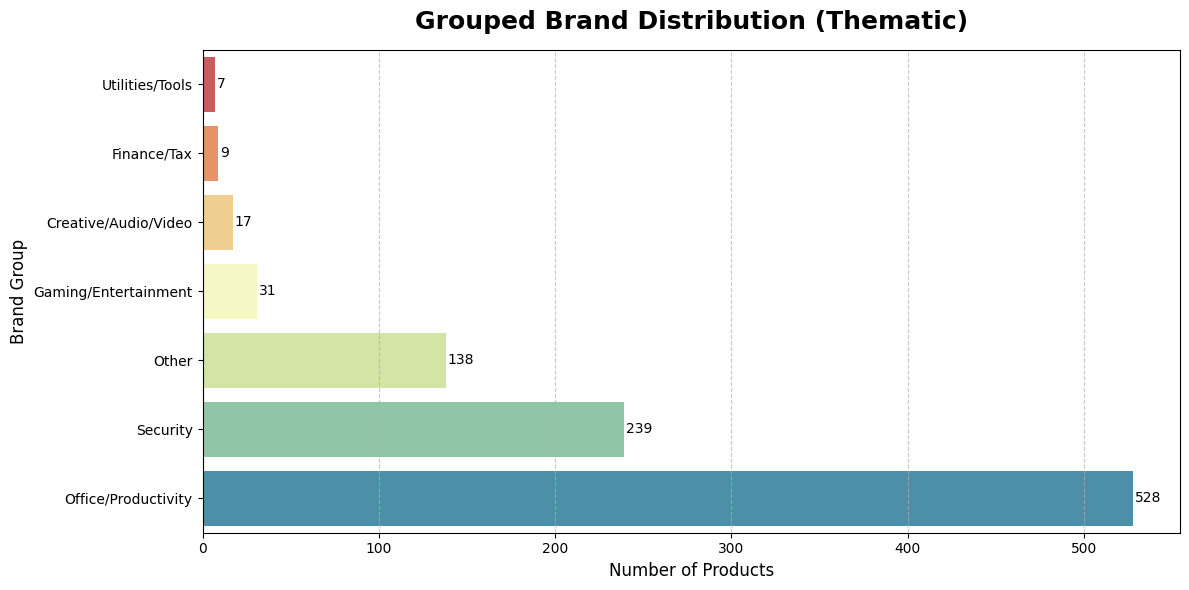

In [20]:
brand_counts = df['brand_grouped_thematic'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=brand_counts.values,
    y=brand_counts.index,
    palette="Spectral"
)
for i, v in enumerate(brand_counts.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontsize=10)

plt.title("Grouped Brand Distribution (Thematic)", fontsize=18, weight="bold", pad=15)
plt.xlabel("Number of Products", fontsize=12)
plt.ylabel("Brand Group", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 3.7 Brand Groups × Country

A **stacked bar chart** showing the distribution of thematic brand groups across different countries.  
This visualization helps to identify regional differences in product categories and highlights which groups dominate specific markets.


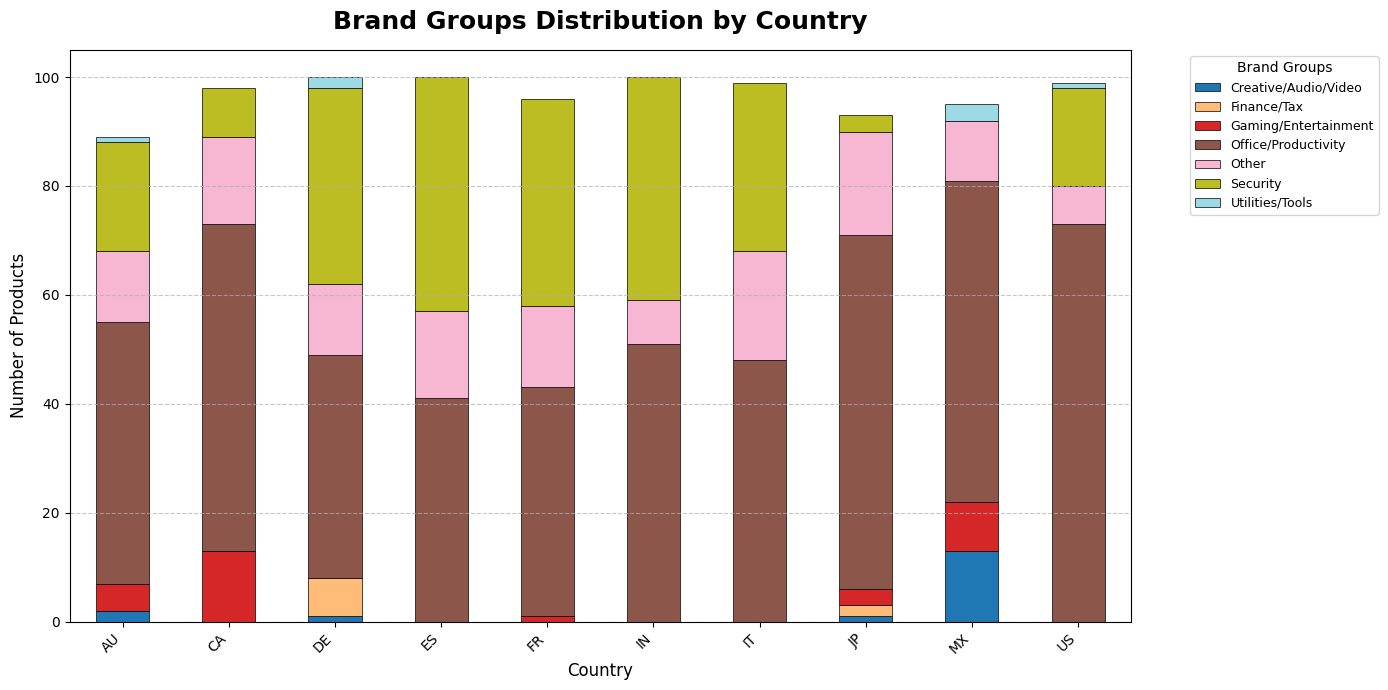

In [21]:
brand_country_grouped = (
    df.groupby(['country', 'brand_grouped_thematic'])
      .size()
      .unstack(fill_value=0)
)

ax = brand_country_grouped.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    colormap="tab20",
    edgecolor="black",
    linewidth=0.5
)

plt.title("Brand Groups Distribution by Country", fontsize=18, weight="bold", pad=15)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Products", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

plt.legend(
    title="Brand Groups",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9
)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### 3.8 Heatmap: Brand vs Country

A **heatmap** visualizing the intensity of brand group presence across countries.  

- Darker shades indicate higher product counts.  
- Provides a quick comparative overview of how brand groups are distributed globally.  
- Complements the stacked bar chart by emphasizing density patterns rather than totals.  


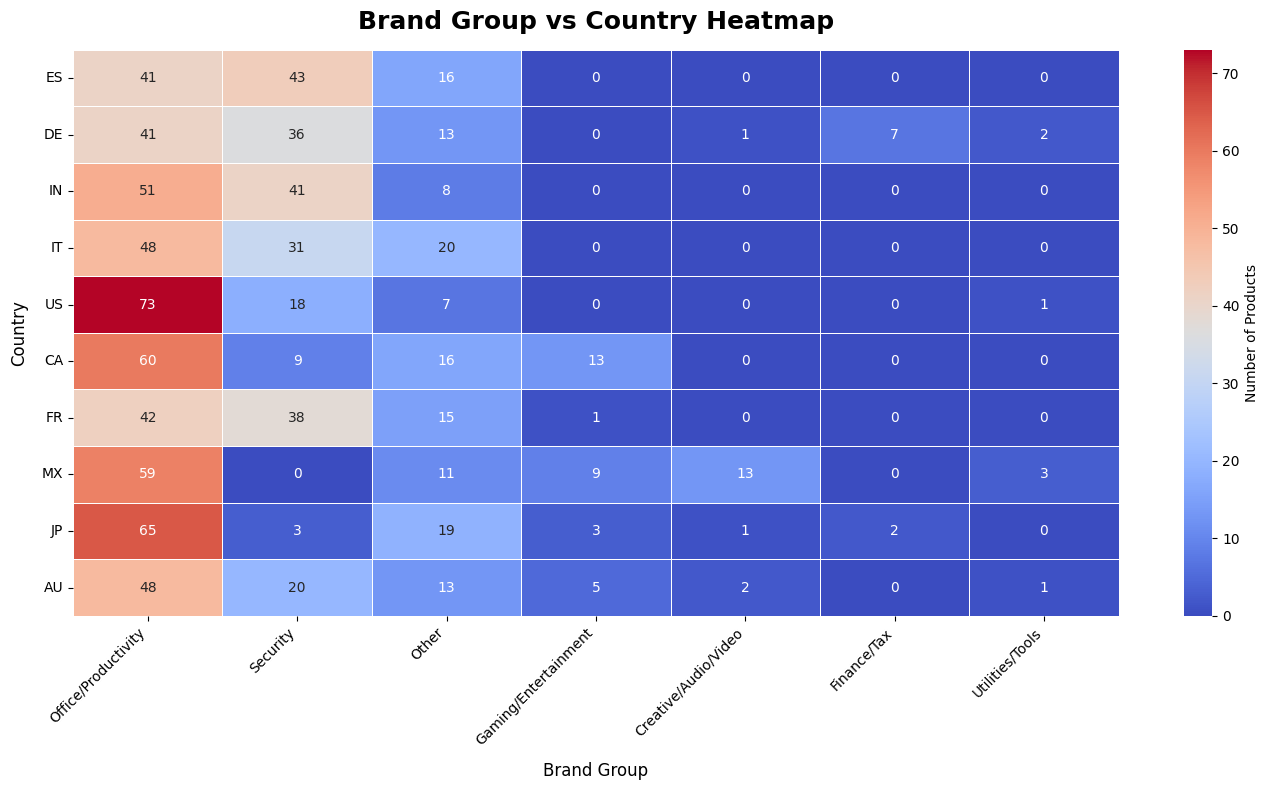

In [22]:
if "brand_country_grouped" not in locals():
    brand_country_grouped = (
        df.groupby(["country", "brand_grouped_thematic"])
          .size()
          .unstack(fill_value=0)
    )

TOP_COUNTRIES = 12
TOP_GROUPS    = 12

top_countries = (
    brand_country_grouped.sum(axis=1)
    .sort_values(ascending=False)
    .head(TOP_COUNTRIES)
    .index
)

top_groups = (
    brand_country_grouped.sum(axis=0)
    .sort_values(ascending=False)
    .head(TOP_GROUPS)
    .index
)

heatmap_df = brand_country_grouped.loc[top_countries, top_groups]

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_df.astype(float),
    cmap="coolwarm",
    linewidths=0.5,
    annot=True,
    fmt=".0f",
    cbar_kws={'label': 'Number of Products'}
)
plt.title("Brand Group vs Country Heatmap", fontsize=18, weight="bold", pad=15)
plt.xlabel("Brand Group", fontsize=12, labelpad=10)
plt.ylabel("Country", fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 4. Price Analysis
In this section we analyze product prices to understand pricing levels, dispersion, and differences across countries and brands.

## 4.1 Price Distribution (Histogram + Boxplot + Summary)
We explore the global distribution of product prices:
- Summary statistics.
- Histogram + KDE to show frequency distribution.
- Boxplot to highlight median, quartiles, and outliers.

count    915.000000
mean      55.444339
std       72.554194
min        0.523886
25%       16.778900
50%       32.689100
75%       65.389100
max      764.340000
Name: clean_price, dtype: float64


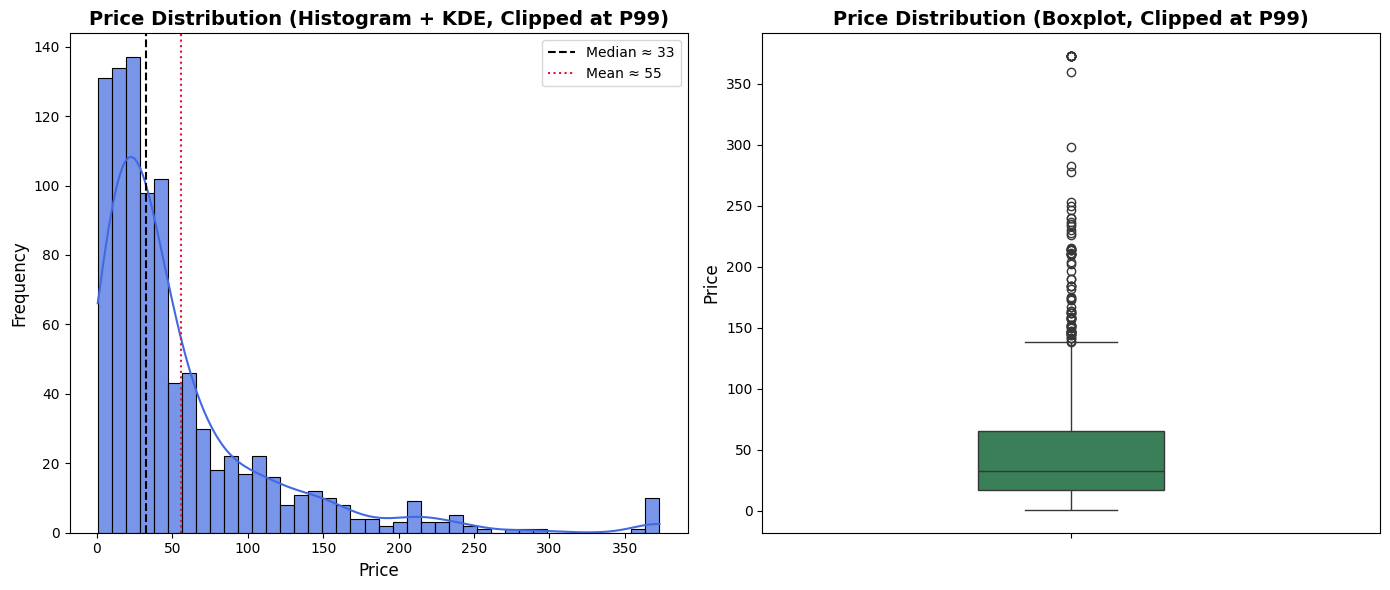

In [23]:
print(df['clean_price'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    df['clean_price'].dropna().clip(upper=df['clean_price'].quantile(0.99)),
    bins=40, kde=True, ax=axes[0], color="royalblue", alpha=0.7
)
axes[0].axvline(df['clean_price'].median(), color="black", linestyle="--", label=f"Median ≈ {df['clean_price'].median():.0f}")
axes[0].axvline(df['clean_price'].mean(), color="crimson", linestyle=":", label=f"Mean ≈ {df['clean_price'].mean():.0f}")
axes[0].set_title("Price Distribution (Histogram + KDE, Clipped at P99)", fontsize=14, weight="bold")
axes[0].set_xlabel("Price", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].legend()

sns.boxplot(
    y=df['clean_price'].dropna().clip(upper=df['clean_price'].quantile(0.99)),
    ax=axes[1], color="seagreen", width=0.3
)
axes[1].set_title("Price Distribution (Boxplot, Clipped at P99)", fontsize=14, weight="bold")
axes[1].set_ylabel("Price", fontsize=12)

plt.tight_layout()
plt.show()


## 4.2 Price Statistics by Country (Mean, Median, Min, Max)
We compare pricing levels across markets:
- Mean and Median for central tendency.
- Minimum and Maximum for extremes.
- Bar plots illustrate variation between countries.

               mean     median        min       max
country                                            
MX       129.692946  86.017200  20.700000  764.3400
AU        73.253900  46.893300   4.683300  297.9691
IT        66.783165  43.589100  11.979100  488.3091
US        64.155312  43.490000   2.990000  374.9900
CA        58.971658  29.200000   8.533700  436.5400
ES        58.727402  43.589100   5.515400  213.6291
FR        53.241958  34.465800   2.953900  457.7891
DE        43.550505  32.214950   8.665500  402.1010
IN        16.405800   8.994000   1.128000  120.0000
JP         7.787208   5.890975   0.523886   30.0160


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\3831801623.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_stats.index, y=price_stats[metric].values, ax=axs[i], palette=[colors[i]]*len(price_stats))
C:\Users\USER\AppData\Local\Temp\ipykernel_10828\3831801623.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_stats.index, y=price_stats[metric].values, ax=axs[i], palette=[colors[i]]*len(price_stats))
C:\Users\USER\AppData\Local\Temp\ipykernel_10828\3831801623.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_

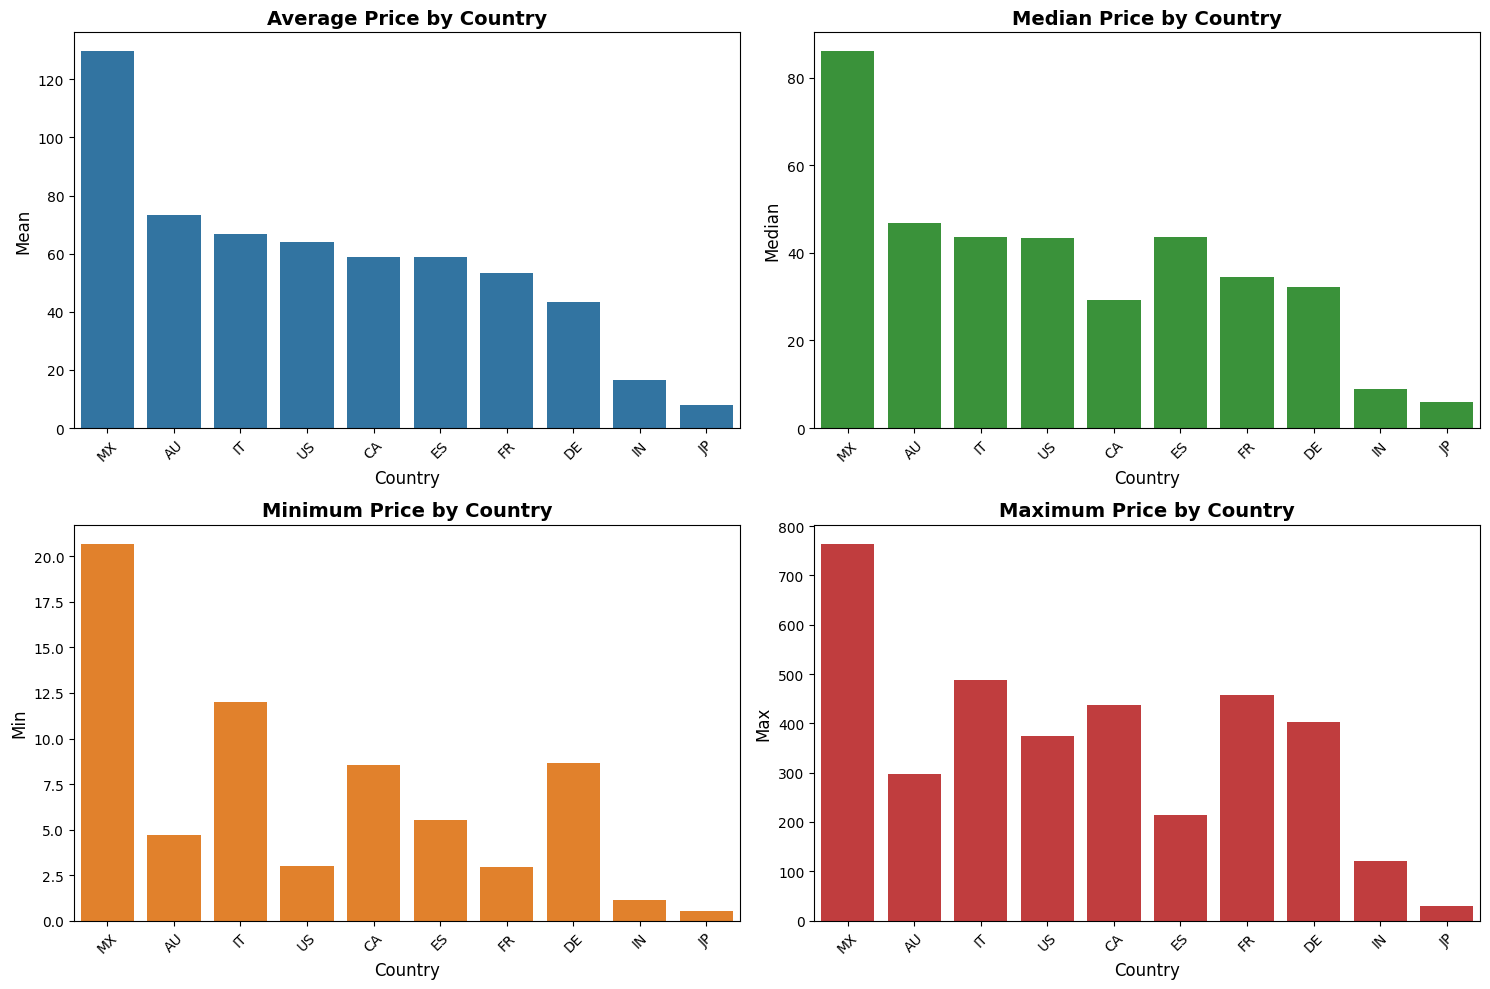

In [24]:
price_stats = (
    df.groupby('country', dropna=False)['clean_price']
      .agg(mean='mean', median='median', min='min', max='max')
      .sort_values('mean', ascending=False)
)
print(price_stats)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axs = axes.ravel()
metrics = ['mean', 'median', 'min', 'max']
titles = ['Average Price', 'Median Price', 'Minimum Price', 'Maximum Price']
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

for i, metric in enumerate(metrics):
    sns.barplot(x=price_stats.index, y=price_stats[metric].values, ax=axs[i], palette=[colors[i]]*len(price_stats))
    axs[i].set_title(f"{titles[i]} by Country", fontsize=14, weight="bold")
    axs[i].set_xlabel("Country", fontsize=12)
    axs[i].set_ylabel(metric.capitalize(), fontsize=12)
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 4.3 Price Distribution by Top Brands (Boxplot with Log Scale)  

We focus on the top 10 brands by product count:  
- Boxplots show median prices, spread, and outliers for each major brand.  
- A **logarithmic scale** is applied to the price axis to improve visibility, reducing the effect of extreme outliers and making typical price ranges easier to compare.  


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\1137754579.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


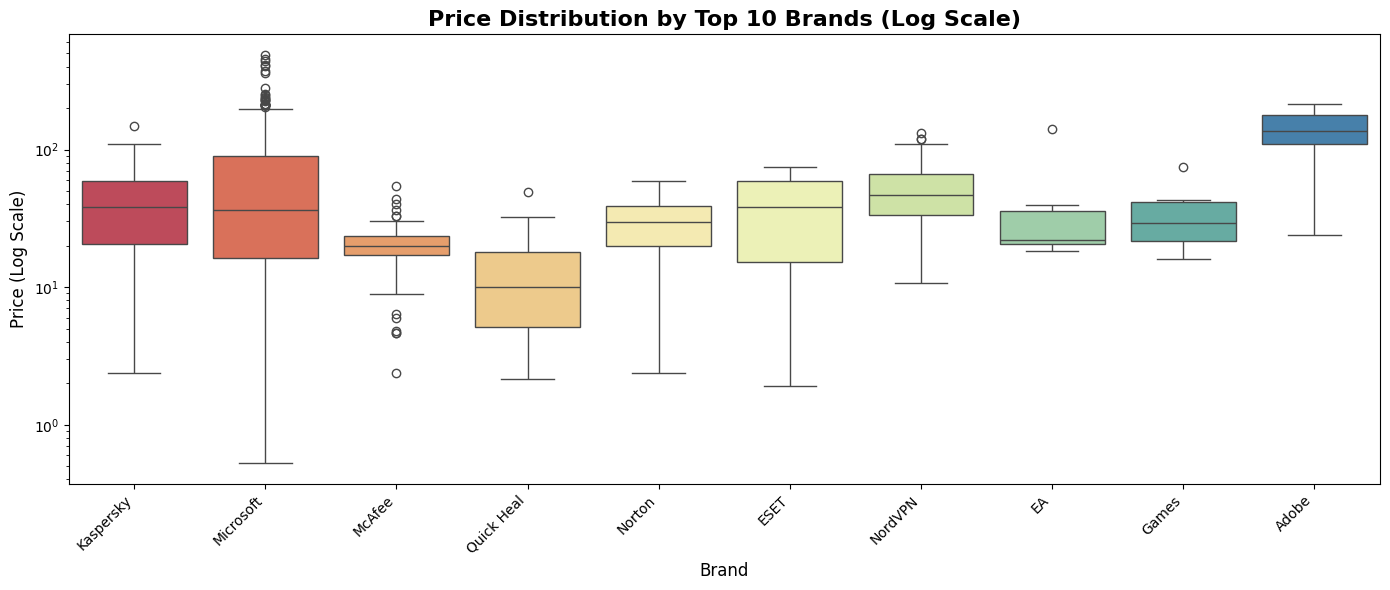

In [25]:
top10_brands = df['brand'].value_counts().head(10).index
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df[df['brand'].isin(top10_brands)],
    x='brand',
    y='clean_price',
    palette="Spectral"
)
plt.yscale("log")
plt.title("Price Distribution by Top 10 Brands (Log Scale)", fontsize=16, weight="bold")
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Price (Log Scale)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 4.4 Price Distribution by Thematic Groups (Boxplot, Log Scale)

We group brands into thematic categories:  
- Boxplots visualize the price distribution per group.  
- A **logarithmic scale** is applied to the price axis to improve readability, minimizing the distortion caused by extreme outliers.  
- This approach highlights differences in typical price ranges across brand groups more clearly.  


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\3993134439.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


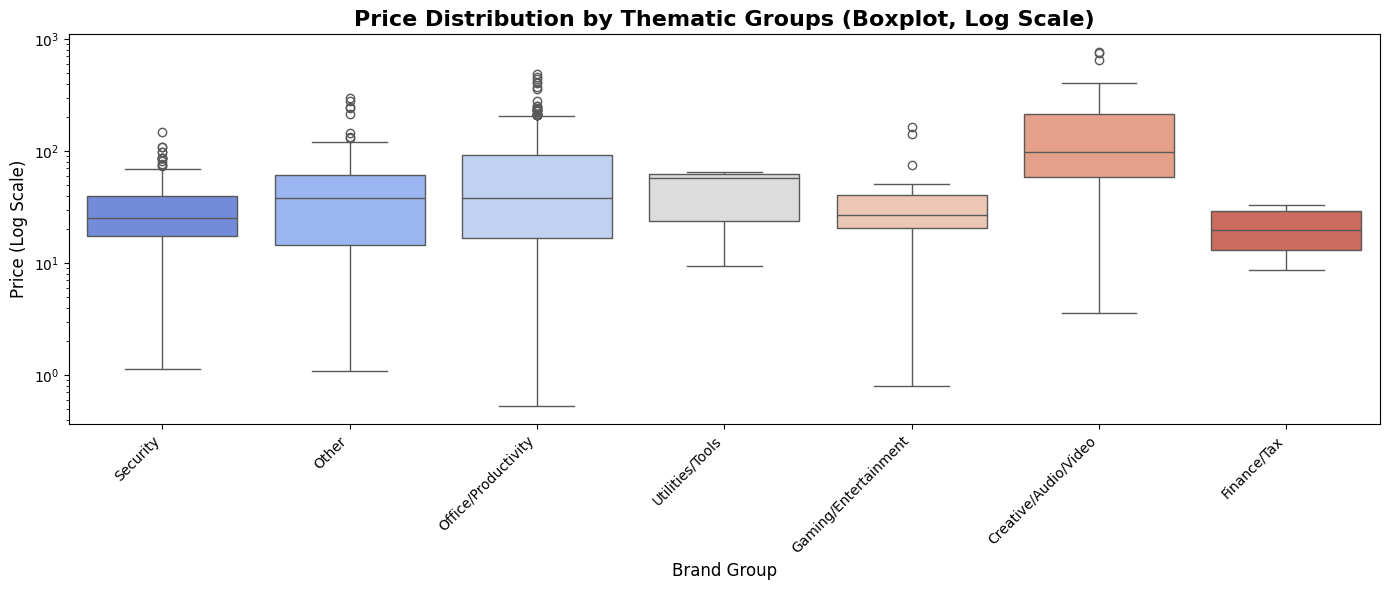

,price
quantile,
0.05,3.34695
0.25,16.77890
0.50,32.68910
0.75,65.38910
0.95,177.17489


In [26]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df.dropna(subset=['clean_price']),
    x='brand_grouped_thematic',
    y='clean_price',
    palette="coolwarm"
)
plt.yscale("log")
plt.title("Price Distribution by Thematic Groups (Boxplot, Log Scale)", fontsize=16, weight="bold")
plt.xlabel("Brand Group", fontsize=12)
plt.ylabel("Price (Log Scale)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

q = df['clean_price'].dropna().quantile([0.05, 0.25, 0.5, 0.75, 0.95]).to_frame("price").rename_axis("quantile")
display(q)



## 5. Ratings Analysis
We analyze the distribution and relationships of product_star_rating after cleaning.


### 5.1 Distribution of Product Star Ratings
This visualization shows the distribution of customer ratings across products.
- A **histogram** combined with a **KDE curve** highlights the frequency of each star rating.
- The summary statistics printed below complement the plot with central tendency and spread (min, max, mean, quartiles).


In [27]:
assert 'product_star_rating' in df.columns, "Column 'product_star_rating' is missing."


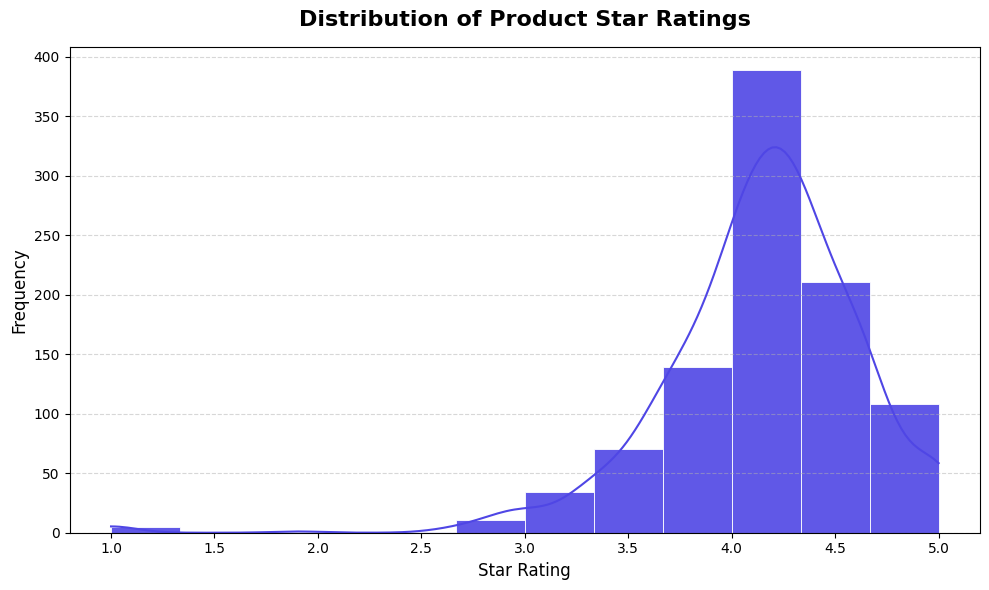

count    969.00
mean       4.14
std        0.50
min        1.00
25%        3.90
50%        4.20
75%        4.40
max        5.00
Name: product_star_rating, dtype: float64


In [28]:
ratings = df['product_star_rating'].dropna()

plt.figure(figsize=(10,6))
ax = sns.histplot(
    ratings,
    bins=12,
    kde=True,
    color="#4f46e5",
    edgecolor="white",
    linewidth=0.6,
    alpha=0.9
)

ax.set_title("Distribution of Product Star Ratings", fontsize=16, weight="bold", pad=15)
ax.set_xlabel("Star Rating", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

from matplotlib.ticker import FuncFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

print(ratings.describe().round(2))


### 5.2 Price vs Rating (Scatterplot)
We explore the relationship between **price** and **customer rating**.
- Prices are shown on a **log scale** to reduce the leverage of extreme values.
- Each point represents a single product.
- Helps identify whether higher-priced items tend to receive higher or lower ratings, and to spot clusters/outliers.


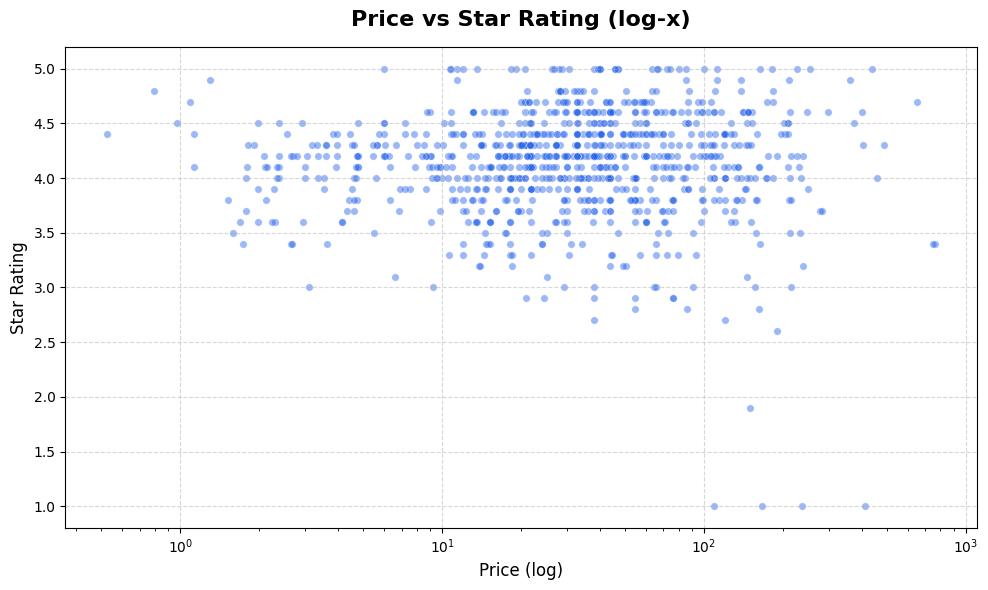

In [29]:
if 'clean_price' not in df.columns:
    raise ValueError("Column 'clean_price' is missing. Create it earlier (e.g., parsed numeric price).")

plot_df = df[['clean_price', 'product_star_rating']].dropna()

plt.figure(figsize=(10,6))
ax = sns.scatterplot(
    data=plot_df,
    x='clean_price',
    y='product_star_rating',
    alpha=0.45,
    s=28,
    color="#2563eb"
)

ax.set_xscale('log')
ax.set_xlabel("Price (log)", fontsize=12)
ax.set_ylabel("Star Rating", fontsize=12)
ax.set_title("Price vs Star Rating (log-x)", fontsize=16, weight="bold", pad=15)

plt.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### 5.3 Star Ratings by Country (Top 8)
We compare rating distributions across the **top countries** by product count.
- **Boxplot** (or Violin) shows median, quartiles, and spread of ratings per country.
- Focus on **Top-8** countries to keep the chart readable while capturing key geographic trends.


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\2599031372.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


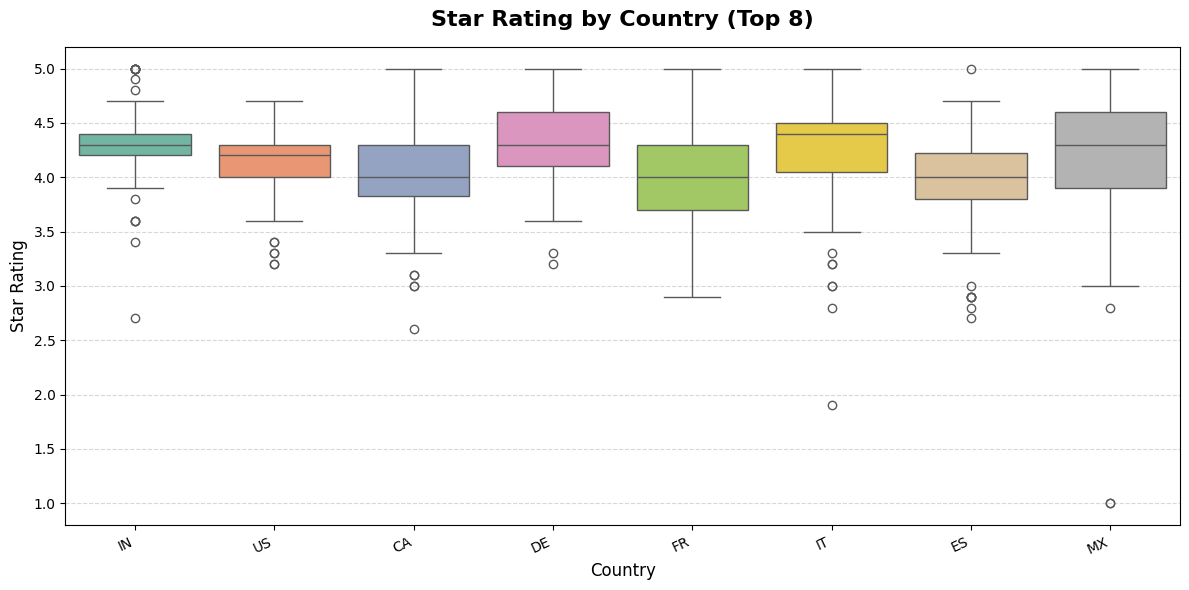

In [30]:
country_col = 'country_norm' if 'country_norm' in df.columns else 'country'
assert country_col in df.columns, "Country column missing ('country' / 'country_norm')."

top_countries = df[country_col].value_counts().index[:8]
tmp = df[df[country_col].isin(top_countries)][[country_col, 'product_star_rating']].dropna()

plt.figure(figsize=(12,6))
ax = sns.boxplot(
    data=tmp,
    x=country_col,
    y='product_star_rating',
    palette="Set2"
)

ax.set_title("Star Rating by Country (Top 8)", fontsize=16, weight="bold", pad=15)
ax.set_xlabel("Country", fontsize=12)
ax.set_ylabel("Star Rating", fontsize=12)

plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### 5.4 Reviews vs Rating (Scatter + Binned Trend)
We examine how **number of reviews** relates to **star rating**.
- Scatter uses a log scale on the x-axis to handle heavy-tailed counts.
- A binned trend line (by quantiles of reviews) shows the average rating across review-volume bands.


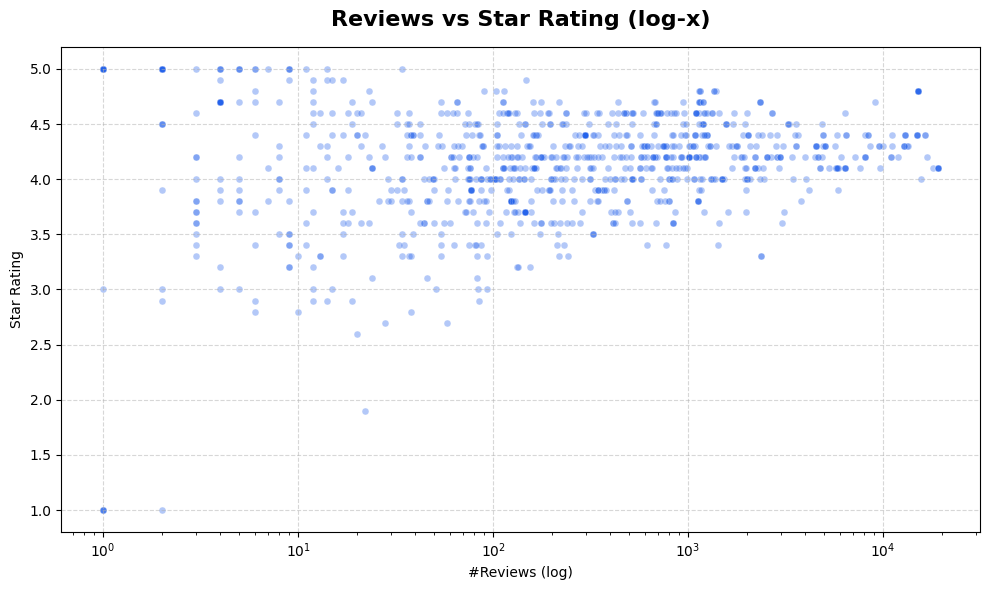

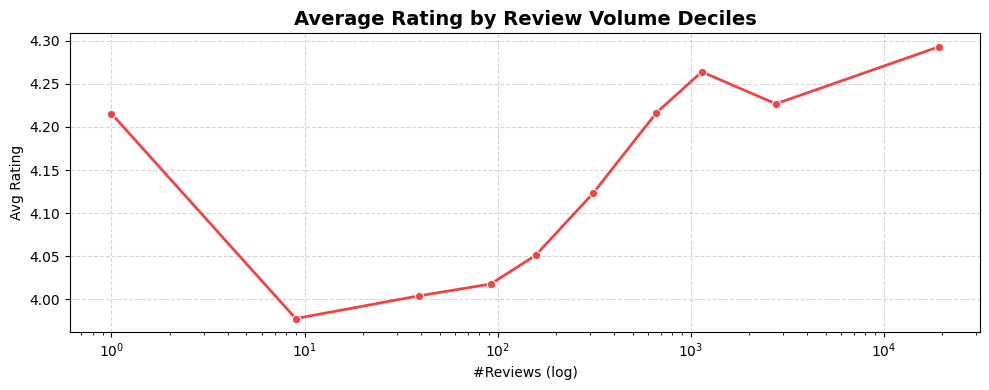

In [31]:
req = ['product_num_ratings', 'product_star_rating']
if any(c not in df.columns for c in req):
    raise ValueError(f"Missing columns: {req}")

d = df[req].dropna()
plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=d, x='product_num_ratings', y='product_star_rating', alpha=0.35, s=24, color="#2563eb")
ax.set_xscale('log')
ax.set_title("Reviews vs Star Rating (log-x)", fontsize=16, weight="bold", pad=15)
ax.set_xlabel("#Reviews (log)"); ax.set_ylabel("Star Rating")
plt.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

bins = pd.qcut(d['product_num_ratings'], q=10, duplicates='drop')
trend = d.groupby(bins, observed=True)['product_star_rating'].mean().reset_index(drop=True)
xpos = d['product_num_ratings'].quantile(np.linspace(0,1,len(trend), endpoint=True)).values

plt.figure(figsize=(10,4))
sns.lineplot(x=xpos, y=trend, marker="o", linewidth=2, color="#ef4444")
plt.xscale('log')
plt.title("Average Rating by Review Volume Deciles", fontsize=14, weight="bold")
plt.xlabel("#Reviews (log)"); plt.ylabel("Avg Rating")
plt.grid(linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### 5.5 Distribution Shape Metrics (Skewness & Kurtosis)
We quantify the shape of the rating distribution:
- **Skewness** indicates asymmetry (positive → right-tail).
- **Kurtosis** indicates tail heaviness (higher → heavier tails).


In [32]:
r = df['product_star_rating'].dropna()
metrics = pd.Series({
    "count": r.size,
    "mean": r.mean(),
    "std": r.std(),
    "skewness": r.skew(),
    "kurtosis": r.kurt()
}).round(4)
display(metrics.to_frame("rating").T)


,count,mean,std,skewness,kurtosis
rating,969.0,4.1402,0.4964,-1.6563,7.8099


### 5.6 Ratings by Price Tiers (Boxplot)
We segment products into three price tiers (Low/Mid/High, by quantiles) and compare rating distributions across tiers.


C:\Users\USER\AppData\Local\Temp\ipykernel_10828\2213694730.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=tmp, x="price_tier", y="rating", palette="Set2")


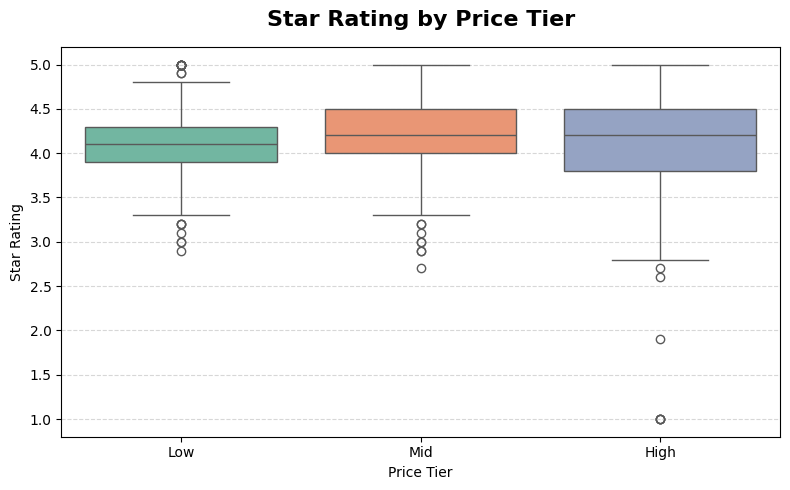

In [33]:
if 'clean_price' not in df.columns:
    raise ValueError("Column 'clean_price' is missing.")

q = df['clean_price'].dropna().quantile([0, 1/3, 2/3, 1]).values
labels = ["Low","Mid","High"]
price_tier = pd.cut(df['clean_price'], bins=q, labels=labels, include_lowest=True, duplicates='drop')
tmp = pd.DataFrame({"price_tier": price_tier, "rating": df['product_star_rating']}).dropna()

plt.figure(figsize=(8,5))
ax = sns.boxplot(data=tmp, x="price_tier", y="rating", palette="Set2")
ax.set_title("Star Rating by Price Tier", fontsize=16, weight="bold", pad=15)
ax.set_xlabel("Price Tier"); ax.set_ylabel("Star Rating")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
